<a href="https://colab.research.google.com/github/MateoPeri/steel-scrap-predictor/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import glob

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from fbprophet import Prophet
import matplotlib.pyplot as plt
import altair as alt
plt.style.use('seaborn-poster')

# Data preparation

In [2]:
!rm -rf '/content/data'
!mkdir data
PATH = '/content/data/'
!wget -P {PATH} https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
!unzip {PATH}raw.zip

--2020-06-06 18:04:52--  https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240524 (235K) [application/zip]
Saving to: ‘/content/data/raw.zip’

raw.zip             100%[===================>] 234.89K  --.-KB/s    in 0.04s   

2020-06-06 18:04:53 (5.45 MB/s) - ‘/content/data/raw.zip’ saved [240524/240524]

Archive:  /content/data/raw.zip
   creating: raw/
  inflating: raw/HC Closing Prices.xlsx  
  inflating: raw/HC Final Settlement prices.xlsx  
  inflating: raw/HU Closing Prices.xlsx  
  inflating: raw/HU Final Settlement prices.xlsx  
  inflating: raw/SC Closing Prices.xlsx  
  inflating: raw/SC Final Settlement prices.xlsx  
  inflating: raw/SR Closing Prices.xlsx  
  inflating: 

In [0]:
def st_to_mt(st):
  return st/1.10231131

In [22]:
pattern = 'raw/*Closing Prices.xlsx'
excels = glob.glob(pattern)

frames = []

for xcel in excels:
  df = pd.read_excel(xcel, parse_dates=True, sep=';', escapechar='\\', encoding='ISO-8859-1', decimal=',', thousands='.')
  name = xcel[4:6]
  if (name == 'HU'):
    # Seleccionar todas las columnas menos USD/st
    cols = [c for c in df.columns if c != 'USD/st (Short Ton)']
    # y aplicarles la funcion st_to_mt para pasar a toneladas métricas
    df[cols] = df[cols].apply(st_to_mt, axis=1)
    # Cambiamos el nombre a la columna
    df.rename({'USD/st (Short Ton)': 'USD/mt'}, axis=1, inplace=True)
  # le añadimos un nombre para saber qué metal es
  df['Metal'] = name
  df.rename({'USD/mt': 'Date'}, axis=1, inplace=True)
  frames.append(df)

df = pd.concat(frames, ignore_index=True)

df.head()

,Date,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M13,M14,M15,Metal
0,2015-11-23,338.0,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,SR
1,2015-11-24,337.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,SR
2,2015-11-25,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,SR
3,2015-11-26,334.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,SR
4,2015-11-27,334.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,SR


In [5]:
# Contamos los valores nulos del dataset -> 0
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835 entries, 0 to 2834
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2835 non-null   datetime64[ns]
 1   M1      2835 non-null   float64       
 2   M2      2835 non-null   float64       
 3   M3      2835 non-null   float64       
 4   M4      2835 non-null   float64       
 5   M5      2835 non-null   float64       
 6   M6      2835 non-null   float64       
 7   M7      2835 non-null   float64       
 8   M8      2835 non-null   float64       
 9   M9      2835 non-null   float64       
 10  M10     2835 non-null   float64       
 11  M11     2835 non-null   float64       
 12  M12     2835 non-null   float64       
 13  M13     2835 non-null   float64       
 14  M14     2835 non-null   float64       
 15  M15     2835 non-null   float64       
 16  Metal   2835 non-null   object        
dtypes: datetime64[ns](1), float64(15), object(1)
memory 

# Data visualization

añadir gráficos

In [0]:
#df.set_index('Date', inplace=True, drop=True)

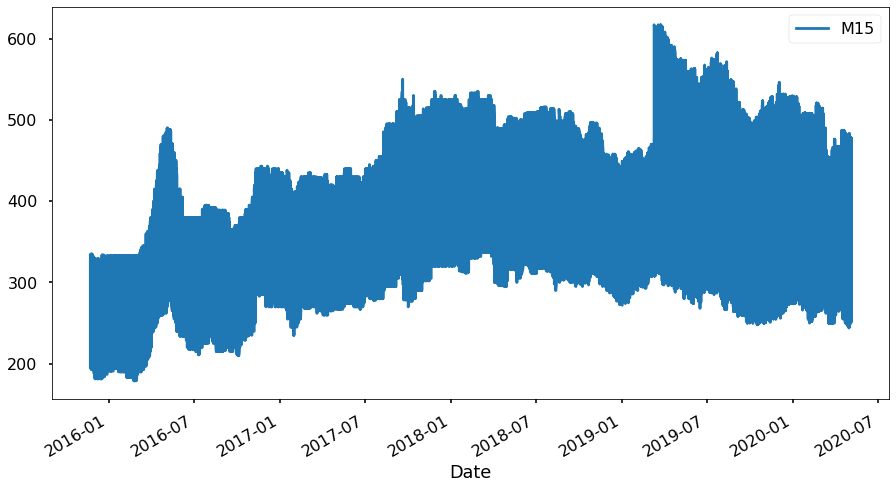

In [27]:
df[['Date', 'M15']].plot('Date', figsize=(15,8))

# Model

In [0]:
#data = df[['Date', 'M3', 'Metal']].copy()
data = df.copy()
data.rename({'Date': 'ds', 'M15': 'y'}, axis=1, inplace=True)

In [0]:
def generate_model(dff):
  fecha = '2015-01-01'

  df_prediccion = dff.loc[dff.ds > fecha].copy()

  p_max = df_prediccion['y'].max()
  p_min = df_prediccion['y'].min()

  df_prediccion['cap'] = p_max
  df_prediccion['floor'] = p_min

  modelo_futuro = Prophet(growth='logistic', seasonality_mode='additive', changepoint_prior_scale=0.05, yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False
            ).add_seasonality(name='daily', period=1,fourier_order=3, prior_scale=0.2
            ).add_seasonality(name='weekly', period=7,fourier_order=3, prior_scale=0.2
            ).add_seasonality(name='monthly', period=30.50,fourier_order=3, prior_scale=0.2
            ).add_seasonality(name='quaterly', period=365.25/4,fourier_order=3, prior_scale=0.1
            ).add_seasonality(name='yearly', period=365.25,fourier_order=4, prior_scale=0.2)
  return modelo_futuro, df_prediccion

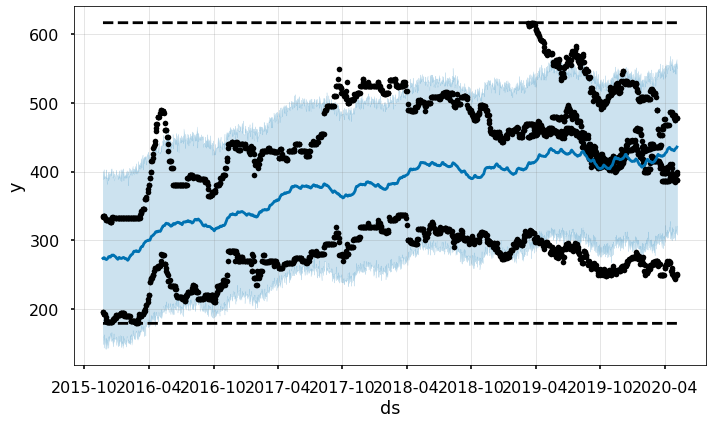

In [31]:
model, df_pred = generate_model(data)
model.fit(df_pred)
forecast = model.predict(df_pred)
fig = model.plot(forecast)

In [32]:
forecast['fact'] = df_pred['y'].reset_index(drop = True)
print('Accuracy: {:.2f}%'.format(r2_score(forecast.fact, forecast.yhat)*100))

Accuracy: -40.38%


In [0]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] == 1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] == -1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

In [34]:
pred = detect_anomalies(forecast)
print(len(pred))
pred = pred[pred.anomaly==0]
print('Accuracy: {:.2f}%'.format(r2_score(pred.fact, pred.yhat)*100))

2835
Accuracy: -50.12%


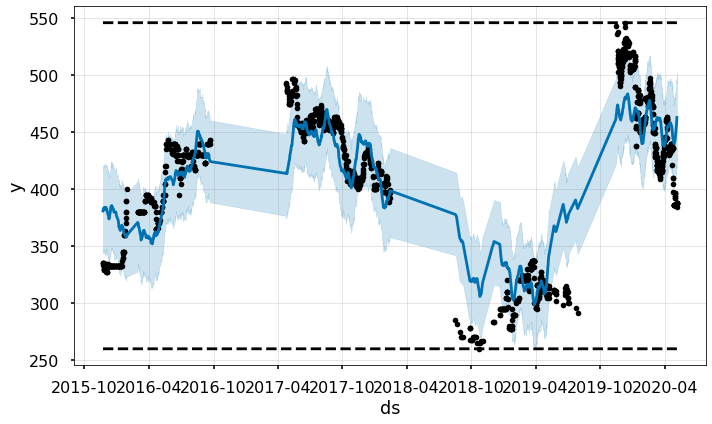

In [35]:
clean_df = pred[['ds', 'fact']]
clean_df.columns = ['ds', 'y']
clean_model, clean_df_pred = generate_model(clean_df.copy())
clean_model.fit(clean_df_pred)
clean_forecast = clean_model.predict(clean_df_pred)
fig2 = clean_model.plot(clean_forecast)

In [36]:
clean_forecast['fact'] = clean_df_pred['y'].reset_index(drop = True)
print('Accuracy: {:.2f}%'.format(r2_score(clean_forecast.fact, clean_forecast.yhat)*100))

Accuracy: 80.34%


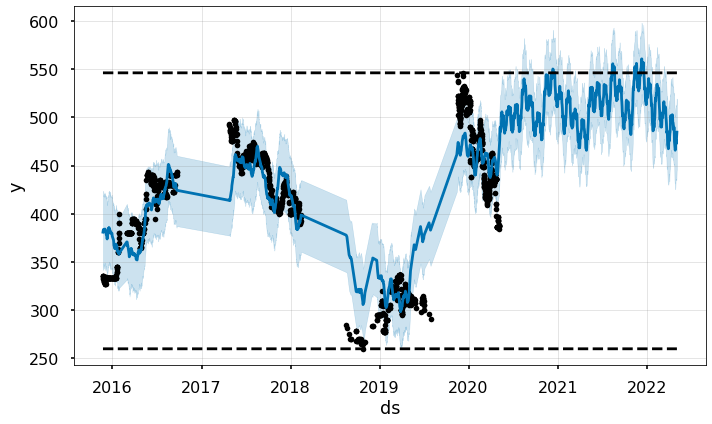

In [37]:
# 2 more years from end of data
future = clean_model.make_future_dataframe(periods=730, freq='d')

p_max = clean_df['y'].max()
p_min = clean_df['y'].min()
future['cap'] = p_max
future['floor'] = p_min
future_forecast = clean_model.predict(future)
fig = clean_model.plot(future_forecast)